In [ ]:
isGoogleDrive = True

In [ ]:
# lib dependency
import soundfile as sf
from scipy import signal
# import random

### Set directories

In [ ]:
if isGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
from glob import glob
path = "./drive/MyDrive/SSSL/HRTF/IRC_*"
names = []
names += glob(path)
print(names[0])

splitnames = [os.path.split(name) for name in names]
print(len(splitnames))

p = re.compile('IRC_\d{4,4}')
print(p)

subjects = [int(name[4:8]) for base, name in splitnames 
                         if not (p.match(name[-8:]) is None)]
print(subjects)

./drive/MyDrive/SSSL/HRTF/IRC_1002
1
re.compile('IRC_\\d{4,4}')
[1002]


### load HRIRs from .mat files

In [ ]:
from scipy.io import loadmat

k = 0
subject = subjects[k]

for k in range(len(names)):
    subject = subjects[k]
    # filename = os.path.join(names[k], 'IRC_' + str(subject))
    filename = os.path.join(names[k], 'COMPENSATED/MAT/HRIR/IRC_' + str(subject) + '_C_HRIR.mat')
#     print(filename)

### Create labels (elevation, azimuth)

dict_keys(['__header__', '__version__', '__globals__', 'r_eq_hrir_S', 'l_eq_hrir_S'])
[('elev_v', 'O'), ('azim_v', 'O'), ('type_s', 'O'), ('sampling_hz', 'O'), ('content_m', 'O')]
locLabel shape:  (187, 2)  (order: elev, azim)
hrirSet shape:  (187, 2, 512)


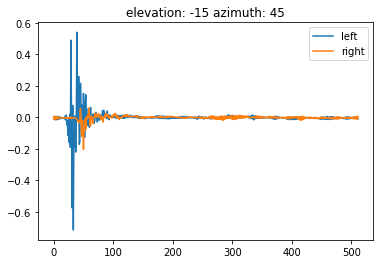

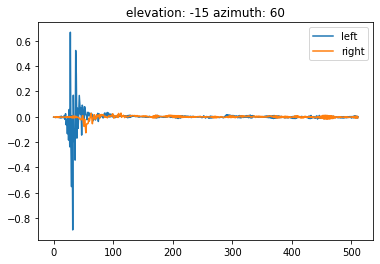

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

m = loadmat(filename, struct_as_record=True)
print(m.keys())
print(m['l_eq_hrir_S'].dtype)

l, r = m['l_eq_hrir_S'], m['r_eq_hrir_S']
hrirSet_l = l['content_m'][0][0]
hrirSet_r = r['content_m'][0][0]
elev = l['elev_v'][0][0]
azim = l['azim_v'][0][0]

locLabel = np.hstack((elev, azim))
print("locLabel shape: ", locLabel.shape, " (order: elev, azim)")
# print(locLabel[0:5])

# 0: left-ear 1: right-ear
hrirSet = np.vstack((np.reshape(hrirSet_l, (1,) + hrirSet_l.shape),
                          np.reshape(hrirSet_r, (1,) + hrirSet_r.shape)))
hrirSet = np.transpose(hrirSet, (1,0,2))
print("hrirSet shape: ", hrirSet.shape)

for i in range(51,53):
    plt.plot(hrirSet[i, 0])
    plt.plot(hrirSet[i, 1])
    plt.legend(['left','right'], loc='best')
    plt.title('elevation: '+str(locLabel[i, 0])+' azimuth: '+str(locLabel[i, 1]))
    plt.show()


### Convolve audio signals with left-ear and right-ear HRIR

Input:

- mono-track audio signal

Output:

- left-ear and right-ear time sequence pairs

In [ ]:
# method to generate audio slices for a given length requirement
# with a hardcoded power threshold
def audioSliceGenerator(audioSeq, sampleRate, lenSliceInSec):
    lenAudio = audioSeq.size
    lenSlice = round(sampleRate * lenSliceInSec)
    # audioSliceList = [range(lenSlice*i, lenSlice *(i+1)) for i in range(lenAudio//lenSlice)]
    # print(len(audioSliceList))
    # print(lenAudio//lenSlice)

    audioSliceList = []
    # threshold for spectrum power
    for i in range(lenAudio//lenSlice):
        sliced = audioSeq[lenSlice*i:lenSlice *(i+1)]
        # print("slice power", np.mean(np.power(sliced, 2)))
        if np.mean(np.power(sliced, 2)) > 0.01:
            audioSliceList.append(range(lenSlice*i, lenSlice *(i+1)))

    return audioSliceList


basedir = os.getcwd()
print(basedir)
# path = glob(os.path.join(basedir, "/drive/MyDrive/SSSL/audio/*"))
path = glob(os.path.join("/content/drive/MyDrive/SSSL/audio/*"))
Naudio = len(path)
print(path)

data, sampleRate = sf.read(path[1])
print(data.shape)
temp2 = audioSliceGenerator(data, sampleRate, 0.5)
print(len(temp2))

/content
['/content/drive/MyDrive/SSSL/audio/music-fma-0001.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0002.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0003.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0004.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0005.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0006.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0008.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0007.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0009.wav']
(3992764,)
471


In [ ]:
import soundfile as sf

basedir = os.getcwd()
print(basedir)
# path = glob(os.path.join(basedir, "/drive/MyDrive/SSSL/audio/*"))
path = glob(os.path.join("/content/drive/MyDrive/SSSL/audio/*"))
Naudio = len(path)
print(path)

# left-ear and right-ear signal pairs
sigPairList = []
audioIndex = -1
Nloc = 23 #hrirSet.shape[1]
lenHRIR = hrirSet.shape[-1]
valSNR = 100
lenSliceInSec = 1

for audioPath in path:
    audioIndex += 1
    audioData, sampleRate = sf.read(audioPath)
    print(data.shape)
    print("Audio sample rate: ", sampleRate)

    audioSliceList = audioSliceGenerator(audioData, sampleRate, lenSliceInSec)

    sliceIndex = -1
    Nsamples = len(audioSliceList)
    print("Number of samples: ",Nsamples)
    lenTruncate = len(audioSliceList[0])
    lenAfterConv = lenHRIR+lenTruncate-1
    
    sigPair = np.zeros((Nsamples, Nloc, 2, lenAfterConv))
    print("Initialise sigPair", sigPair.shape)

    for audioSlice in audioSliceList:
        sliceIndex += 1
        audio = audioData[audioSlice]
        lenAfterConv = lenHRIR+audio.size-1
        # print(len(audioSlice))
        # shape after convolution: 512 + audio length - 1

        # hrirSet is of shape (187, 2, 512)
        for locIndex in range(Nloc): 
            sigLeft = np.convolve(audio, hrirSet[locIndex, 0])
            sigRight = np.convolve(audio, hrirSet[locIndex, 1])

            sigPair[sliceIndex, locIndex, 0] = sigLeft.reshape(1, sigLeft.shape[0])
            sigPair[sliceIndex, locIndex, 1] = sigRight.reshape(1, sigRight.shape[0])

    sigPairList.append(sigPair)


/content
['/content/drive/MyDrive/SSSL/audio/music-fma-0001.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0002.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0003.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0004.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0005.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0006.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0008.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0007.wav', '/content/drive/MyDrive/SSSL/audio/music-fma-0009.wav']
(3992764,)
Audio sample rate:  16000
Number of samples:  210
Initialise sigPair (210, 23, 2, 16511)
(3992764,)
Audio sample rate:  16000
Number of samples:  236
Initialise sigPair (236, 23, 2, 16511)
(3992764,)
Audio sample rate:  16000
Number of samples:  311
Initialise sigPair (311, 23, 2, 16511)
(3992764,)
Audio sample rate:  16000
Number of samples:  294
Initialise sigPair (294, 23, 2, 16511)
(3992764,)
Audio sample rate:  16000
Number of samples:  269
Initialise sigPair (269, 

9
(210, 23, 2, 16511)


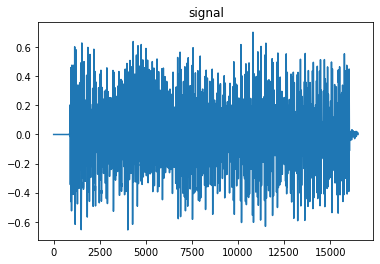

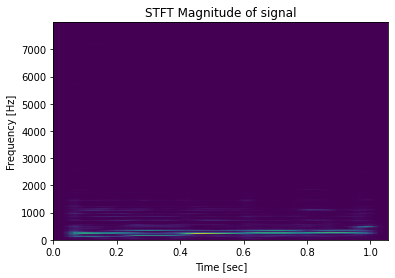

In [ ]:
print(len(sigPairList))
print(sigPairList[0].shape)
isPlot = True
if isPlot:
    plt.plot(sigPairList[0][0,0,0])
    plt.title("signal")
    plt.show()

    # plt.plot(noiseRight[0])
    # plt.title("noise")
    # plt.show()

    f, t, Zxx = signal.stft(sigPairList[0][0,0,0], sampleRate, nperseg=1023)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('STFT Magnitude of signal')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    # f, t, Zxx = signal.stft(noiseRight[0], sampleRate, nperseg=1023)
    # plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    # plt.title('STFT Magnitude of noise')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()


#### Store arrays as files

In [ ]:
# import h5py
# h5f = h5py.File('/content/drive/My Drive/data.h5', 'w')
# h5f.create_dataset('dataset_1', data=sigPairList[audioIndex])

# with h5py.File('/content/drive/My Drive/data.h5', 'w') as hf:
#     hf.create_dataset("dataset_1",  data=sigPairList[audioIndex])

for audioIndex in range(len(sigPairList)):
    fileName="/content/drive/MyDrive/SSSL/npy/array"+str(audioIndex)+".npy"
    with open(fileName, 'wb') as f:
        np.save(f, sigPairList[audioIndex])

# fileName="/content/drive/MyDrive/array7.npy"
# with open(fileName, 'wb') as f:
#     np.save(f, sigPairList[7])


#### Test: load from saved .npy files

In [ ]:
import numpy as np
sigPair = np.load('/content/drive/MyDrive/SSSL/npy/array0.npy')
print(sigPair.shape)
sigPairList = []
sigPairList.append(sigPair)
# del sigPair

(210, 23, 2, 16511)


In [ ]:
sigPairList = []
for i in range(0, 7):
    sigPair = np.load('/content/drive/MyDrive/SSSL/npy/array'+str(i)+'.npy')
    # print(type(temp))
    print(i,' ',sigPair.shape)
    sigPairList.append(sigPair)

0   (210, 23, 2, 16511)
1   (236, 23, 2, 16511)
2   (311, 23, 2, 16511)
3   (294, 23, 2, 16511)
4   (269, 23, 2, 16511)
5   (269, 23, 2, 16511)


In [ ]:
print(sigPairList[0].shape)

(210, 23, 2, 16511)


### Add noise

Run when the training data is in RAM

In [ ]:
# method to generate a sequence of noise for a given SNR
def noiseGenerator(sigSeq, valSNR):
    # assert debug
    # assert (
    #     sigSeq.shape[0] == 1
    # ), "Input data needs to be reshaped to (1, length of sequence)"

    sigSeqPower = 10*np.log10(np.mean(np.power(sigSeq, 2)))
    noisePower = np.power(10, (sigSeqPower - valSNR)/10)
    return np.random.normal(0, np.sqrt(noisePower), sigSeq.shape)


In [ ]:
print(len(sigPairList))
print(sigPairList[0].shape)

def addNoise(sigPair):
    valSNR = 1
    # loop through all training examples
    for i in range(sigPairList[0].shape[0]):
        # loop through all locations
        for locIndex in range(sigPairList[0].shape[1]):
            noiseLeft = noiseGenerator(np.expand_dims(sigPairList[0][i,locIndex,0], axis=0), valSNR)
            noiseRight = noiseGenerator(np.expand_dims(sigPairList[0][i,locIndex,1], axis=0), valSNR)





1
(436, 23, 2, 8511)


In [ ]:
sigPair = sigPairList[0]
del sigPairList
sigPairList = []
sigPairList.append(sigPair)

### Windowed FFT

Input:

- left-ear and right-ear time sequences

Output:

- left-ear and right-ear time-varying spectra



(210, 23, 2, 16511)


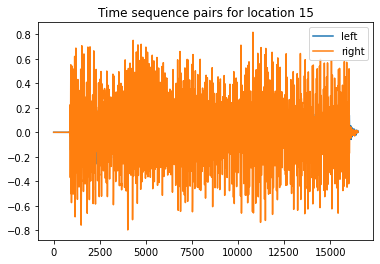

16000
(512, 34)


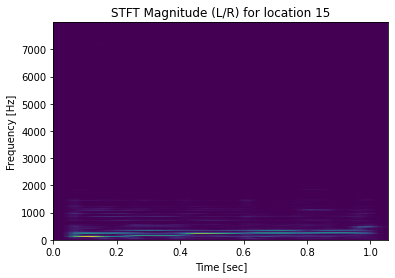

In [ ]:
# visualise left-ear and right-ear signal pairs and their spectrogram
from scipy import signal
import random

print(sigPairList[0].shape)
randomExample = 0
randomLoc = random.randint(0, sigPairList[0].shape[1] - 1)
plt.plot(sigPairList[0][randomExample, randomLoc, 0])
plt.plot(sigPairList[0][randomExample, randomLoc, 1])
plt.title('Time sequence pairs for location '+str(randomLoc))
plt.legend(['left','right'])
plt.show()

fs = 16000 #sampleRate
print(fs)

f, t, Zxx = signal.stft(sigPairList[0][randomExample, randomLoc, 0], fs, nperseg=1023)
print(Zxx.shape)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude (L/R) for location '+str(randomLoc))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Extract binaural cues

- IPD cues (similar as ITD (ambiguous at high frequencies))

  arg(S_l/S_r)
  
  
- Spectral cues (essentially tells about ILD cues)

  do STFT and then convert it to magnitude and phase

In [ ]:
def cartesian2euler(val):
    x = val.real
    y = val.imag
    
    r = np.sqrt(x**2+y**2)

    theta = np.arctan(
        np.divide(y, x, where=x!=0)
    )
    # if x != 0:
    #     theta = np.arctan(y/x)
    # else:
    #     theta = np.pi/2
        
    return normalise(r), normalise(theta)

def calIPD(seqL, seqR):
    temp = np.divide(seqL, seqR, out=np.zeros_like(seqL), where=seqR!=0)
    ipd = np.arctan(np.divide(np.imag(temp), np.real(temp), out=np.zeros_like(np.real(temp)), where=np.real(temp)!=0))
    return ipd

def normalise(seq):
    return seq/np.linalg.norm(seq)

temp = np.array([[1, 2, 3],[1,2,3]])
print(normalise(temp))

[[0.18898224 0.37796447 0.56694671]
 [0.18898224 0.37796447 0.56694671]]


In [ ]:
from scipy import signal
import random

def binauralCues(sigPair, fs, valSNR):
    f, t, Zxx = signal.stft(sigPair[0, 0, 0], fs, nperseg=1023)
    # spectralCues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]) + (4,), dtype='float')
    # ipdCues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]), dtype='float')
    cues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]) + (5,), dtype='float')

    del f, t, Zxx

    for i in range(sigPair.shape[0]):
        for locIndex in range(sigPair.shape[1]):
            
            f_l, t_l, Zxx_l = signal.stft(
                sigPair[i, locIndex, 0] 
                # + noiseGenerator(sigPair[i, locIndex, 0], valSNR)
                , fs, nperseg = 1023
            )              
                                          
            f_r, t_r, Zxx_r = signal.stft(
                sigPair[i, locIndex, 1] 
                # + noiseGenerator(sigPair[i, locIndex, 1], valSNR)
                , fs, nperseg = 1023
            )
            # print(Zxx_l.shape)
            # print(Zxx_r.shape)

            r_l, theta_l = cartesian2euler(Zxx_l)
            r_r, theta_r = cartesian2euler(Zxx_r)

            # ipdCues[i, locIndex] = normalise(np.transpose(calIPD(Zxx_l, Zxx_r), (1, 0)))
            # spectralCues[i, locIndex] = np.transpose(np.array([r_l, theta_l, r_r, theta_r]), (2, 1 ,0))
            cues[i, locIndex] = np.concatenate(
                (np.expand_dims(
                    normalise(np.transpose(calIPD(Zxx_l, Zxx_r), (1, 0))), axis=-1
                    ),
                 np.transpose(np.array([r_l, theta_l, r_r, theta_r]), (2, 1 ,0))
                 ),
                 axis=-1
            )
    return cues
    # return ipdCues, spectralCues

print(sigPair.shape)
cues = binauralCues(sigPair, 16000, 100)
    

(210, 23, 2, 16511)


In [ ]:
print(cues.shape)

(210, 23, 34, 512, 5)


In [ ]:
# calculate spectral and IPD cues
spectralCuesList = []
ipdCuesList = []
for audioIndex in range(len(sigPairList)):
    spectralCues = np.zeros(sigPairList[audioIndex].shape[:-2] + (Zxx.shape[1], Zxx.shape[0]) + (4,), dtype='float')
    ipdCues = np.zeros(sigPairList[audioIndex].shape[:-2] + (Zxx.shape[1], Zxx.shape[0]), dtype='float')
    print("IPD shape", ipdCues.shape)
    print(sigPairList[audioIndex].shape)

    for i in range(sigPairList[audioIndex].shape[0]):
        if i%100 == 1:
            print("Sample ",i)
        for locIndex in range(sigPairList[audioIndex].shape[1]):
            f_l, t_l, Zxx_l = signal.stft(sigPairList[audioIndex][i, locIndex, 0], fs, nperseg=1023)
            f_r, t_r, Zxx_r = signal.stft(sigPairList[audioIndex][i, locIndex, 1], fs, nperseg=1023)
    #         print(Zxx_l.shape)
            
            ipdCues[i, locIndex] = normalise(np.transpose(calIPD(Zxx_l, Zxx_r), (1, 0)))
            
            r_l, theta_l = cartesian2euler(Zxx_l)
            r_r, theta_r = cartesian2euler(Zxx_r)
            # temp = np.array([r_l, theta_l, r_r, theta_r])
            # print(temp.shape)
            spectralCues[i, locIndex] = np.transpose(np.array([r_l, theta_l, r_r, theta_r]), (2, 1 ,0))
            
            # for timeIndex in range(Zxx_l.shape[1]):
            #     for freqIndex in range(Zxx_l.shape[0]):
            #         r_l, theta_l = cartesian2euler(Zxx_l[freqIndex][timeIndex])
            #         r_r, theta_r = cartesian2euler(Zxx_r[freqIndex][timeIndex])

            #         spectralCues[i, locIndex, timeIndex, freqIndex] = np.array([r_l, theta_l, r_r, theta_r])
                    # print(spectralCues[i, locIndex, timeIndex, freqIndex].shape)
                    
            
    ipdCues = np.transpose(ipdCues, (1, 0, 2, 3))
    spectralCues = np.transpose(spectralCues, (1, 0, 2, 3, 4))

    ipdCuesList.append(ipdCues)
    spectralCuesList.append(spectralCues)


In [ ]:
print("Size of feature matrices:")
print(ipdCues.shape)
print(spectralCues.shape)


Size of feature matrices:
(269, 23, 34, 512)
(269, 23, 34, 512, 4)


#### Data visualisation

In [ ]:
# IPD visualisation

# plt.plot(ipdCues[0,0,100:105,:])

# plt.pcolormesh(t_l, f_l, np.abs(ipdCues[random.randint(0,186), 0]), shading='gouraud')
# plt.title('IPD cues')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show() 

In [ ]:
# plt.pcolormesh(t, f, spectralCues[random.randint(0,186), 0, :,:,3], shading='gouraud')
# plt.title('Spectral cues (left-ear)')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()
# plt.show()


### Tensorisation

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
from torch.autograd import Variable
import torch.nn.functional as F

cues_ = torch.from_numpy(cues.astype(np.float32))
Nloc = cues_.shape[1]
labels = np.zeros((cues_.shape[0], cues_.shape[1], 1)).astype(np.long)
for i in range(cues.shape[0]):
    for j in range(cues.shape[1]):
        labels[i,j] = j

labels_ = torch.from_numpy(labels)

cues_ = cues_.reshape(cues_.shape[0] * cues_.shape[1], cues_.shape[2], cues_.shape[3], cues_.shape[4])
labels_ = labels_.reshape(labels_.shape[0]*labels_.shape[1], 1)

dataset_ = TensorDataset(cues_, labels_)


print("cues shape: ",cues.shape)
print("cues_ shape: ",cues_.shape)
print("labels shape",labels.shape)
print("labels_ shape: ",labels_.shape)

cues shape:  (210, 23, 34, 512, 5)
cues_ shape:  torch.Size([4830, 34, 512, 5])
labels shape (210, 23, 1)
labels_ shape:  torch.Size([4830, 1])


In [ ]:
batch_size = 32
Ntrain = round(0.6*cues_.shape[0])
if Ntrain % batch_size == 1:
    Ntrain -=1
Nvalid = round(0.2*cues_.shape[0])
if Nvalid % batch_size == 1:
    Nvalid -=1
Ntest = cues_.shape[0] - Ntrain - Nvalid
if Ntest % batch_size == 1:
    Ntest -=1
print("Dataset separation: ",Ntrain, Nvalid, Ntest)

train, valid, test = torch.utils.data.random_split(dataset_, [Ntrain, Nvalid, Ntest], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset=valid, batch_size=32, shuffle=True, num_workers=0)


Dataset separation:  2898 966 966


## Transformer

### Model 1

From scratch

In [69]:
class SelfAttention(nn.Module):
    def __init__(self, freqSize, heads):
        super(SelfAttention, self).__init__()
        self.freqSize = freqSize
        self.heads = heads
        self.head_dim = freqSize // heads

        # assert debug
        assert (
            self.head_dim * heads == freqSize
        ), "Embedding size needs to be divisible by heads"

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, freqSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        # Split the embedding into self.heads different pieces
        value = value.reshape(N, value_time, self.heads, self.head_dim)
        key = key.reshape(N, key_time, self.heads, self.head_dim)
        query = query.reshape(N, query_time, self.heads, self.head_dim)

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.freqSize ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_time, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class Attention(nn.Module):
    def __init__(self, embedSize, locSize):
        super(Attention, self).__init__()
        self.embedSize = embedSize

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(embedSize, embedSize, bias=False)
        self.keys = nn.Linear(embedSize, embedSize, bias=False)
        self.queries = nn.Linear(embedSize, embedSize, bias=False)
        self.fc_out = nn.Linear(embedSize, locSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        energy = torch.einsum("ntqe,ntke->neqk", [queries, keys])

        attention = torch.softmax(energy / (self.embedSize ** (1 / 2)), dim=3)

        out = torch.einsum("neqk,ntve->ntqe", [attention, values]).reshape(
            N, query_time, query_freq, self.embedSize
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, freqSize, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(freqSize, heads)
        self.norm1 = nn.LayerNorm(freqSize)
        self.norm2 = nn.LayerNorm(freqSize)

        self.feed_forward = nn.Sequential(
            nn.Linear(freqSize, forward_expansion * freqSize),
            nn.ReLU(),
            nn.Linear(forward_expansion * freqSize, freqSize),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention = self.attention(value, key, query)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        freqSize, # frequency bins
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
    ):

        super(Encoder, self).__init__()
        self.freqSize = freqSize
        self.device = device

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    freqSize,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        timeSize, freqSize = x.shape[-2], x.shape[-1]
        # positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(x)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out)

        return out

class SSSL(nn.Module):
    def __init__(
    self,
    locSize,
    timeSize, # time windows
    freqSize, # frequency bins
    num_layers,
    heads,
    device,
    forward_expansion,
    dropout,
    isDebug
    ):
        super(SSSL, self).__init__()
        self.encoder = Encoder(           
            freqSize, # frequency bins
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
        )
        self.attention = Attention(5, locSize)
        self.fcFreq = nn.Linear(freqSize, 1)
        self.fcTime = nn.Linear(timeSize, 1)
        self.isDebug = isDebug
        self.dropout = nn.Dropout(dropout)
        # self.softmaxLayer = nn.Softmax(dim = -1)
    def forward(self, cues_):
        enc_ipd = self.encoder(cues_[:,:,:,0])
        if self.isDebug == True:
            print("enc_ipd shape: ",enc_ipd.shape)
        enc_slMag = self.encoder(cues_[:,:,:,1])
        enc_slPhase = self.encoder(cues_[:,:,:,2])
        enc_srMag = self.encoder(cues_[:,:,:,3])
        enc_srPhase = self.encoder(cues_[:,:,:,4])
        enc = torch.stack([enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase])
        # del enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase
        enc = enc.permute(1,2,3,0)
        # encCat = torch.cat((enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase), -1)
        # print(enc.shape)
        if self.isDebug == True:
            print("enc shape: ",enc.shape)

        attOut = self.attention(enc, enc, enc)
        if self.isDebug == True:
            print("attOut shape: ",attOut.shape)

        out = self.fcFreq(attOut.permute(0,1,3,2))
        out = out.squeeze(-1)
        # out = self.dropout(out)

        # out = torch.mean(attOut, -2)
        # out = out.squeeze(-1)
        if self.isDebug == True:
            print("FC freq shape: ",out.shape)
        
        out = self.fcTime(out.permute(0, 2, 1))
        out = out.squeeze(-1)
        # out = self.dropout(out)

        # out = torch.mean(out, -2)
        # out = out.squeeze(-2)
        if self.isDebug == True:
            print("FC time shape: ",out.shape)


        # out = self.softmaxLayer(out)
        return out

Nfreq = cues_.shape[2]
print(Nfreq)
Ntime = cues_.shape[1]
print(Ntime)
# Nloc = cues_.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
numLayers = 3
model = SSSL(Nloc, Ntime, Nfreq, numLayers, 8, device, 4, 0, False).to(device)
testInput = cues_[-3:-1].to(device)
testLabel = labels_[-3:-1].to(device)
testOutput = model(testInput)
print(testInput.shape)
print(testOutput.shape)


512
34
torch.Size([2, 34, 512, 5])
torch.Size([2, 23])


In [ ]:
torch.cuda.memory_summary(device=device, abbreviated=False)
# !nvidia-smi

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  155837 KB |  168790 KB |  198586 KB |   42749 KB |\n|       from large pool |   72760 KB |   83000 KB |   86128 KB |   13368 KB |\n|       from small pool |   83077 KB |   85790 KB |  112458 KB |   29381 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |  155837 KB |  168790 KB |  198586 KB |   42749 KB |\n|       from large pool |   72760 KB |   83000 KB |

### Model 2

Using Pytorch implementation

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, freqSize, heads):
        super(SelfAttention, self).__init__()
        self.freqSize = freqSize
        self.heads = heads
        self.head_dim = freqSize // heads

        # assert debug
        assert (
            self.head_dim * heads == freqSize
        ), "Embedding size needs to be divisible by heads"

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, freqSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]
        
        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        # Split the embedding into self.heads different pieces
        value = value.reshape(N, value_time, self.heads, self.head_dim)
        key = key.reshape(N, key_time, self.heads, self.head_dim)
        query = query.reshape(N, query_time, self.heads, self.head_dim)

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.freqSize ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_time, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class Attention(nn.Module):
    def __init__(self, embedSize, locSize):
        super(Attention, self).__init__()
        self.embedSize = embedSize

        # obtain Q K V matrices by linear transformation
        self.values = nn.Linear(embedSize, embedSize, bias=False)
        self.keys = nn.Linear(embedSize, embedSize, bias=False)
        self.queries = nn.Linear(embedSize, embedSize, bias=False)
        self.fc_out = nn.Linear(embedSize, locSize)

    def forward(self, value, key, query):
        # Get number of training examples
        N = query.shape[0]

        value_time, value_freq = value.shape[1], value.shape[2]
        key_time, key_freq = key.shape[1], key.shape[2]
        query_time, query_freq = query.shape[1], query.shape[2]

        values = self.values(value)  # (N, value_len, heads, head_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        energy = torch.einsum("ntqe,ntke->neqk", [queries, keys])

        attention = torch.softmax(energy / (self.embedSize ** (1 / 2)), dim=3)

        out = torch.einsum("neqk,ntve->ntqe", [attention, values]).reshape(
            N, query_time, query_freq, self.embedSize
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, freqSize, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(freqSize, heads)
        self.norm1 = nn.LayerNorm(freqSize)
        self.norm2 = nn.LayerNorm(freqSize)

        self.feed_forward = nn.Sequential(
            nn.Linear(freqSize, forward_expansion * freqSize),
            nn.ReLU(),
            nn.Linear(forward_expansion * freqSize, freqSize),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention = self.attention(value, key, query)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        freqSize, # frequency bins
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
    ):

        super(Encoder, self).__init__()
        self.freqSize = freqSize
        self.device = device

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    freqSize,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        timeSize, freqSize = x.shape[-2], x.shape[-1]
        # positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(x)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out)

        return out

class SSSL(nn.Module):
    def __init__(
    self,
    locSize,
    timeSize, # time windows
    freqSize, # frequency bins
    num_layers,
    heads,
    device,
    forward_expansion,
    dropout,
    isDebug
    ):
        super(SSSL, self).__init__()

        transformer_layers = nn.TransformerEncoderLayer(
            freqSize, heads, 2048, dropout
        )
        self.encoder = nn.TransformerEncoder(transformer_layers, num_layers)

        # self.encoder = Encoder(           
        #     freqSize, # frequency bins
        #     num_layers,
        #     heads,
        #     device,
        #     forward_expansion,
        #     dropout,
        # )
        self.isDebug = isDebug
        self.attention = Attention(5, locSize)
        self.fcFreq = nn.Linear(freqSize, 1)
        self.fcTime = nn.Linear(timeSize, 1)
        # self.softmaxLayer = nn.Softmax(dim = -1)
    def forward(self, ipd, slMag, slPhase, srMag, srPhase):
        enc_ipd = self.encoder(ipd)
        if self.isDebug == True:
            print("enc_ipd shape: ",enc_ipd.shape)
        enc_slMag = self.encoder(slMag)
        enc_slPhase = self.encoder(slPhase)
        enc_srMag = self.encoder(srMag)
        enc_srPhase = self.encoder(srPhase)
        enc = torch.stack([enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase])
        enc = enc.permute(1,2,3,0)
        # encCat = torch.cat((enc_ipd, enc_slMag, enc_slPhase, enc_srMag, enc_srPhase), -1)
        # print(enc.shape)

        attOut = self.attention(enc, enc, enc)
        # print(enc_ipd.shape)
        if self.isDebug == True:
            print("Attention output shape: ",attOut.shape)

        out = self.fcFreq(attOut.permute(0,1,3,2))
        out = out.squeeze(-1)
        if self.isDebug == True:
            print("FC freq shape: ",out.shape)

        # out = torch.mean(attOut, -2)
        # out = out.squeeze(-1)
        # print(out.shape)
        out = self.fcTime(out.permute(0,2,1))
        out = out.squeeze(-1)
        if self.isDebug == True:
            print("FC time shape: ",out.shape)

        # out = torch.mean(out, -2)
        # out = out.squeeze(-2)


        # out = self.softmaxLayer(out)
        return out

Nfreq = ipd_.shape[2]
print(Nfreq)
Ntime = ipd_.shape[1]
print(Ntime)
# Nloc = 187
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
numLayers = 6
model = SSSL(Nloc, Ntime, Nfreq, numLayers, 8, device, 4, 0, False).to(device)
testOut = model(ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device),ipd_[0:2].to(device))
print(ipd_[0:2].shape)
print(testOut.shape)

512
18
cuda
torch.Size([2, 18, 512])
torch.Size([2, 23])


### Network training

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# numLayers = 6
# model = SSSL(Nloc, Ntime, Nfreq, numLayers, 8, device, 4, 0, False).to(device)

num_epochs = 100
learning_rate = 1e-4
# batch_size = 32
early_epoch = 100
new_early_epoch = 0
new_val_loss = 0.0

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    print("\nEpoch %d" % (epoch + 1))
    model.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    for i, data in enumerate(train_loader, 0):
        length = len(train_loader)
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)

        outputs = model(inputs)

        # print("Input shape: ",inputs.shape)
        # print("Ouput shape: ", outputs.shape)
        # print("Label shape: ", labels.shape)
        loss = criterion(outputs, labels.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.squeeze(1).data).sum().item()
    print("correct: %d | total: %d"
        % (correct, total))
    print('Training Loss: %.04f | Training Acc: %.4f%% '
        % (sum_loss / (i + 1), 100.0 * correct / total))
    

    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, labels.squeeze(1))
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels.squeeze(1).data).sum().item()
        scheduler.step(val_loss)

    print('Val_Loss: %.04f | Val_Acc: %.4f%% '
        % (val_loss, 100.0 * val_correct / val_total))

    if (100.0 * val_correct / val_total <= new_val_loss):
        new_early_epoch += 1
    else:
        new_val_loss = 100.0 * val_correct / val_total
        new_early_epoch = 0
    if (new_early_epoch >= early_epoch):
        break


Epoch 1
correct: 131 | total: 2898
Training Loss: 3.1328 | Training Acc: 4.5204% 
Val_Loss: 3.0447 | Val_Acc: 4.9689% 

Epoch 2
correct: 152 | total: 2898
Training Loss: 3.0012 | Training Acc: 5.2450% 
Val_Loss: 3.1406 | Val_Acc: 9.5238% 

Epoch 3
correct: 193 | total: 2898
Training Loss: 2.8332 | Training Acc: 6.6598% 
Val_Loss: 2.6827 | Val_Acc: 9.5238% 

Epoch 4
correct: 280 | total: 2898
Training Loss: 2.6769 | Training Acc: 9.6618% 
Val_Loss: 2.9492 | Val_Acc: 12.1118% 

Epoch 5
correct: 311 | total: 2898
Training Loss: 2.5966 | Training Acc: 10.7315% 
Val_Loss: 2.3114 | Val_Acc: 12.9400% 

Epoch 6
correct: 400 | total: 2898
Training Loss: 2.5056 | Training Acc: 13.8026% 
Val_Loss: 2.4885 | Val_Acc: 16.5631% 

Epoch 7
correct: 490 | total: 2898
Training Loss: 2.4318 | Training Acc: 16.9082% 
Val_Loss: 2.3693 | Val_Acc: 19.9793% 

Epoch 8
correct: 592 | total: 2898
Training Loss: 2.3183 | Training Acc: 20.4279% 
Val_Loss: 2.0245 | Val_Acc: 23.4990% 

Epoch 9
correct: 766 | total: 

KeyboardInterrupt: ignored

In [ ]:
# loss = criterion(outputs, labels)
for i, data in enumerate(train_loader, 0):
    print(i,' ',len(data),'',data[0].shape,' ',data[1].shape)

In [ ]:
_, predicted = torch.max(outputs.data, 1)
print(predicted)
print(labels.squeeze(1))

tensor([21, 21, 15,  8, 15, 22, 12, 22,  8, 22, 11, 12, 22, 21, 12, 20, 12, 20,
        10, 10, 22, 10, 22, 11,  8,  4, 21, 15,  8,  4, 20, 20],
       device='cuda:0')
tensor([ 5, 16, 17, 14, 21, 22, 13, 12,  3,  8, 21,  1,  4, 12,  3, 16, 20,  9,
        18,  0, 12,  8,  1, 21,  8,  9,  5,  6, 19,  5, 19, 12],
       device='cuda:0')


# New section

In [ ]:
from scipy import signal
import random
import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
sigPairList = []
for i in range(0, 7):
    sigPair = np.load('/content/drive/MyDrive/SSSL/npy/array'+str(i)+'.npy')
    print(i,' ',sigPair.shape)
    sigPairList.append(sigPair)

0   (210, 23, 2, 16511)
1   (236, 23, 2, 16511)
2   (311, 23, 2, 16511)
3   (294, 23, 2, 16511)
4   (269, 23, 2, 16511)
5   (269, 23, 2, 16511)


In [ ]:
def cartesian2euler(val):
    x = val.real
    y = val.imag
    
    r = np.sqrt(x**2+y**2)

    theta = np.arctan(
        np.divide(y, x, where=x!=0)
    )
    # if x != 0:
    #     theta = np.arctan(y/x)
    # else:
    #     theta = np.pi/2
        
    return normalise(r), normalise(theta)

def calIPD(seqL, seqR):
    temp = np.divide(seqL, seqR, out=np.zeros_like(seqL), where=seqR!=0)
    ipd = np.arctan(np.divide(np.imag(temp), np.real(temp), out=np.zeros_like(np.real(temp)), where=np.real(temp)!=0))
    return ipd

def normalise(seq):
    return seq/np.linalg.norm(seq)

# method to generate a sequence of noise for a given SNR
def noiseGenerator(sigSeq, valSNR):
    # assert debug
    # assert (
    #     sigSeq.shape[0] == 1
    # ), "Input data needs to be reshaped to (1, length of sequence)"

    sigSeqPower = 10*np.log10(np.mean(np.power(sigSeq, 2)))
    noisePower = np.power(10, (sigSeqPower - valSNR)/10)
    return np.random.normal(0, np.sqrt(noisePower), sigSeq.shape)


def binauralCues(sigPair, fs, valSNR=1):
    f, t, Zxx = signal.stft(sigPair[0, 0, 0], fs, nperseg=1023)
    cues = np.zeros(sigPair.shape[:-2] + (Zxx.shape[1], Zxx.shape[0]) + (5,), dtype='float')

    del f, t, Zxx

    for i in range(sigPair.shape[0]):
        for locIndex in range(sigPair.shape[1]):
            
            f_l, t_l, Zxx_l = signal.stft(
                sigPair[i, locIndex, 0] 
                + noiseGenerator(sigPair[i, locIndex, 0], valSNR)
                , fs, nperseg = 1023
            )              
                                          
            f_r, t_r, Zxx_r = signal.stft(
                sigPair[i, locIndex, 1] 
                + noiseGenerator(sigPair[i, locIndex, 1], valSNR)
                , fs, nperseg = 1023
            )
            # print(Zxx_l.shape)
            # print(Zxx_r.shape)

            r_l, theta_l = cartesian2euler(Zxx_l)
            r_r, theta_r = cartesian2euler(Zxx_r)

            cues[i, locIndex] = np.concatenate(
                (np.expand_dims(
                    normalise(np.transpose(calIPD(Zxx_l, Zxx_r), (1, 0))), axis=-1
                    ),
                 np.transpose(np.array([r_l, theta_l, r_r, theta_r]), (2, 1 ,0))
                 ),
                 axis=-1
            )
    return cues

# class Trainer()
#     def __init__(
#         self,
#         num_epochs = 100,
#         learning_rate = 1e-4,
#         batch_size = 32,
#         early_epoch = 100,
#         new_early_epoch = 0,
#         new_val_loss = 0.0,
#     ):

def ModelTrainer(model, dataset_):
    batch_size = 32
    Ntrain = round(0.6*cues_.shape[0])
    if Ntrain % batch_size == 1:
        Ntrain -=1
    Nvalid = round(0.2*cues_.shape[0])
    if Nvalid % batch_size == 1:
        Nvalid -=1
    Ntest = cues_.shape[0] - Ntrain - Nvalid
    if Ntest % batch_size == 1:
        Ntest -=1
    print("Dataset separation: ",Ntrain, Nvalid, Ntest)

    train, valid, test = torch.utils.data.random_split(dataset_, [Ntrain, Nvalid, Ntest], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True, num_workers=0)
    valid_loader = DataLoader(dataset=valid, batch_size=32, shuffle=True, num_workers=0)

    # training phase settings
    num_epochs = 100
    learning_rate = 1e-4
    early_epoch = 100
    new_early_epoch = 0
    new_val_loss = 0.0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20, verbose=True)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print("\nEpoch %d" % (epoch + 1))
        model.train()
        sum_loss = 0.0
        correct = 0.0
        total = 0.0

        for i, data in enumerate(train_loader, 0):
            length = len(train_loader)
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)

            outputs = model(inputs)

            # print("Input shape: ",inputs.shape)
            # print("Ouput shape: ", outputs.shape)
            # print("Label shape: ", labels.shape)
            loss = criterion(outputs, labels.squeeze(1))
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.squeeze(1).data).sum().item()
        print("correct:",correct)
        print("total",total)
        print('Training Loss: %.04f | Training Acc: %.4f%% '
            % (sum_loss / (i + 1), 100.0 * correct / total))
        

        val_loss = 0.0
        val_correct = 0.0
        val_total = 0.0

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_loader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).to(device), Variable(labels.long()).to(device)
                
                outputs = model(inputs)
                val_loss = criterion(outputs, labels.squeeze(1))
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels.squeeze(1).data).sum().item()
            scheduler.step(val_loss)

        print('Val_Loss: %.04f | Val_Acc: %.4f%% '
            % (val_loss, 100.0 * val_correct / val_total))

        if (100.0 * val_correct / val_total <= new_val_loss):
            new_early_epoch += 1
        else:
            new_val_loss = 100.0 * val_correct / val_total
            new_early_epoch = 0
        if (new_early_epoch >= early_epoch):
            break



In [ ]:
cuesList = []
for i in range(0,2): # lenAudio = 7
    sigPair = np.load('/content/drive/MyDrive/SSSL/npy/array'+str(i)+'.npy')
    print(i,' ',sigPair.shape)

    cues = binauralCues(sigPair, 16000, valSNR=10)
    del sigPair
    cuesList.append(cues)
    # del cues

cues = np.concatenate((cuesList[0], cuesList[1]),axis=0)
# del cuesList

# tensorisation
cues_ = torch.from_numpy(cues.astype(np.float32))
print(cues_.shape)
Nloc = cues_.shape[1]
labels = np.zeros((cues_.shape[0], cues_.shape[1], 1)).astype(np.long)
for i in range(cues.shape[0]):
    for j in range(cues.shape[1]):
        labels[i,j] = j

labels_ = torch.from_numpy(labels)

cues_ = cues_.reshape(cues_.shape[0] * cues_.shape[1], cues_.shape[2], cues_.shape[3], cues_.shape[4])
labels_ = labels_.reshape(labels_.shape[0] * labels_.shape[1], 1)

print("cues shape: ",cues.shape)
print("cues_ shape: ",cues_.shape)
print("labels shape: ",labels.shape)
print("labels_ shape: ",labels_.shape)

del cues, labels
# create tensorDataset
dataset_ = TensorDataset(cues_, labels_)


0   (210, 23, 2, 16511)
1   (236, 23, 2, 16511)
torch.Size([446, 23, 34, 512, 5])
cues shape:  (446, 23, 34, 512, 5)
cues_ shape:  torch.Size([10258, 34, 512, 5])
labels shape:  (446, 23, 1)
labels_ shape:  torch.Size([10258, 1])


In [70]:
print(len(dataset_))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SSSL(23, 34, 512, 6, 8, device, 4, 0, False).to(device)
ModelTrainer(model, dataset_)

10258
Dataset separation:  6155 2052 2051

Epoch 1
correct: 567.0
total 6155.0
Training Loss: 2.9467 | Training Acc: 9.2120% 
Val_Loss: 2.2521 | Val_Acc: 19.8343% 

Epoch 2
correct: 1812.0
total 6155.0
Training Loss: 2.0225 | Training Acc: 29.4395% 
Val_Loss: 2.5116 | Val_Acc: 42.2027% 

Epoch 3
correct: 3174.0
total 6155.0
Training Loss: 1.4571 | Training Acc: 51.5678% 
Val_Loss: 1.8043 | Val_Acc: 59.5517% 

Epoch 4
correct: 4495.0
total 6155.0
Training Loss: 0.9188 | Training Acc: 73.0301% 
Val_Loss: 0.1134 | Val_Acc: 73.2943% 

Epoch 5
correct: 5471.0
total 6155.0
Training Loss: 0.3986 | Training Acc: 88.8871% 
Val_Loss: 2.1925 | Val_Acc: 72.8070% 

Epoch 6
correct: 5874.0
total 6155.0
Training Loss: 0.1737 | Training Acc: 95.4346% 
Val_Loss: 0.1352 | Val_Acc: 85.2339% 

Epoch 7
correct: 6030.0
total 6155.0
Training Loss: 0.0861 | Training Acc: 97.9691% 
Val_Loss: 5.4375 | Val_Acc: 83.9669% 

Epoch 8
correct: 6030.0
total 6155.0
Training Loss: 0.0798 | Training Acc: 97.9691% 
Val_Lo